In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster, MousePosition

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ind_file = "/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/v54.1_1240K_public.ind"
geno_csv_file = "/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/rs1343879.csv"
anno_file = "/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/v54.1_1240K_public.anno"

# My notes

Looking at ancient DNA representation in MAGEE2 (rs1343879) 

|gene|snpid|chrom|position|ancestral|derived|
|-|-|-|-|-|-|
|MAGEE2|rs1343879|X|75004529|C|A|

The [dataset](https://reich.hms.harvard.edu/allen-ancient-dna-resource-aadr-downloadable-genotypes-present-day-and-ancient-dna-data) I'm using is the 1240K version 12651 unique individuals (8755 ancient, 3896 present-day).

The anno, snp and ind files are readily readable, not geno file (need to use eigensoft). Luckily, conda.

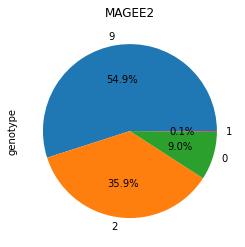

In [5]:
def read_entry(entryfile):
    df =  pd.read_csv(entryfile, sep = "\t",
                      names = ["snpid", "chrom", "gen_loc", "phys_loc", "ancestral", "derived", "genotypes"])
    return df

def get_genotypes(entryfile):
    df = read_entry(entryfile)
    return [int(g) for g in df["genotypes"].tolist()[0]]

def get_samples_genotypes(indfile, entryfile):
    ind = pd.read_csv(indfile, sep = " ", names = ["sampleid", "gender", "status"], index_col = 0)
    ind["genotype"] = get_genotypes(entryfile)
    return ind

def count_genos_proportion(indfile, entryfile):
    df = get_samples_genotypes(indfile, entryfile)
    return pd.DataFrame(df["genotype"].value_counts(normalize = True))

def plot_genos_proportion(indfile, entryfile):
    fig, ax = plt.subplots()
    df = get_samples_genotypes(indfile, entryfile)
    df["genotype"].value_counts()\
        .plot(kind = "pie", autopct='%1.1f%%', ax = ax)
    return fig, ax

fig, ax = plot_genos_proportion(ind_file, geno_csv_file)
ax.set_title("MAGEE2")
plt.show()

In [6]:
count_genos_proportion(ind_file, geno_csv_file)

,genotype
9,0.549435
2,0.359347
0,0.089761
1,0.001458


|genotype|meaning|
|-|-|
|0|zero copies of reference allele.
|1|one copy of reference allele.
|2|two copies of reference allele.
|9|missing data.

Focusing on the spatiotemporal trend on these snps, interesting metadata are
- Date mean in BP
- Date standard deviation
- GroupID
- Locality
- Country
- Lat.
- Long.
- Sex

These metadata are of interest

|Abbr|Description|
|--|--|
|HG|hunter-gatherer|
|N|Neolithic|
|C|Chalcolithic/CopperAge|
|BA|BronzeAge|
|IA|IronAge|


In [7]:
def groupid_of_interest(string):
    for groupid in ["HG", "N", "C", "BA", "IA"]:
        if f"_{groupid}_" in string:
            return True
    return False

In [8]:
metadatadf = pd.read_csv(anno_file, sep = "\t", index_col = 0)

metadatadf.rename(
    columns = {
        "Date mean in BP [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]": "Date BP"
    },
    inplace = True
)

# keep only interested metadata
metadata_of_interest = [
    "Date BP", "Group ID", "Locality", "Country", "Lat.", "Long.", "Molecular Sex"
]

metadatadf = metadatadf.loc[:, metadata_of_interest]
print(metadatadf.shape)

# remove modern samples
# metadatadf = metadatadf.loc[metadatadf["Date BP"] > 0, :]
# print(metadatadf.shape)

# # get groupID of interest
# groupid_list = [i for i in metadatadf["GroupID"].unique() if groupid_of_interest(i)]
# metadatadf = metadatadf.loc[metadatadf["GroupID"].isin(groupid_list), :]
# print(metadatadf.shape)

(16465, 7)


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
metadatadf.head()

,Date BP,Group ID,Locality,Country,Lat.,Long.,Molecular Sex
sampleid,,,,,,,
Ne30_genotyping_noUDG,9896,China_AmurRiver_EarlyN,"Nepal, Kathmandu",China,45.96,126.23,M
Ne61_genotyping_noUDG,3421,China_AmurRiver_BA,"Nepal, Kathmandu",China,45.88,126.22,U
Ne35_genotyping_noUDG,8990,China_AmurRiver_EarlyN,"Nepal, Kathmandu",China,45.91,125.95,F
I17622,3050,Albania_BA_IA_lc,"Southwest, Dukat",Albania,40.295,19.49027778,M
I13833,325,Albania_EarlyModern_oCaucasus,"Barç (Southeast, Korça Basin)",Albania,40.625278,20.801111,M


In [10]:
def print_example_metadata(metadata, n = None, narrowcriteria = None):
    df = metadatadf.copy()
    
    if narrowcriteria != None:
        try:
            narrowmetadata, narrowvalue = narrowcriteria[0], narrowcriteria[1]
            df = df.loc[df[narrowmetadata] == narrowvalue, :]
        except:
            print(f"narrowcriteria has to be a tuple (metadata, value)")
    
    if n == None:
        df = df[metadata].value_counts()
    else:
        df = df[metadata].value_counts()[:n]
    return pd.DataFrame(df)
    
    
print_example_metadata("Country", 5)

,Country
China,1198
United Kingdom,1171
USA,808
Russia,771
Italy,759


In [11]:
def dist_geno_by_metadata(indfile, entryfile, metadata, narrowlist = None):
    fig, ax = plt.subplots(figsize = (8,4), dpi = 200)
    df =  pd.merge(
        get_samples_genotypes(indfile, entryfile),
        metadatadf,
        left_index = True,
        right_index = True
    )
    
    # remove modern samples
    df = df.loc[df["Date BP"] > 0]
    print(df.shape)
    
    df = df.groupby([metadata, "genotype"])\
            .size()
    df = pd.DataFrame(df)
    df.reset_index(inplace = True)
    df.set_index(metadata, inplace = True)
    
    df.rename(columns = {0: "count"}, inplace = True)
    df = df.pivot(columns = "genotype")

    # #Cause got extra china with a space after it
    # df.loc["China", ("count", 9)] += df.loc["China ", ("count", 9)]

 
    if narrowlist != None:
        try:
            df = df.loc[narrowlist]
        except:
            print(f"{narrowlist} not in {metadata} column")
            pass

    df.plot.barh(ax = ax)
    
    return fig, ax

(10061, 10)


(<Figure size 1600x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5b67ee2160>)

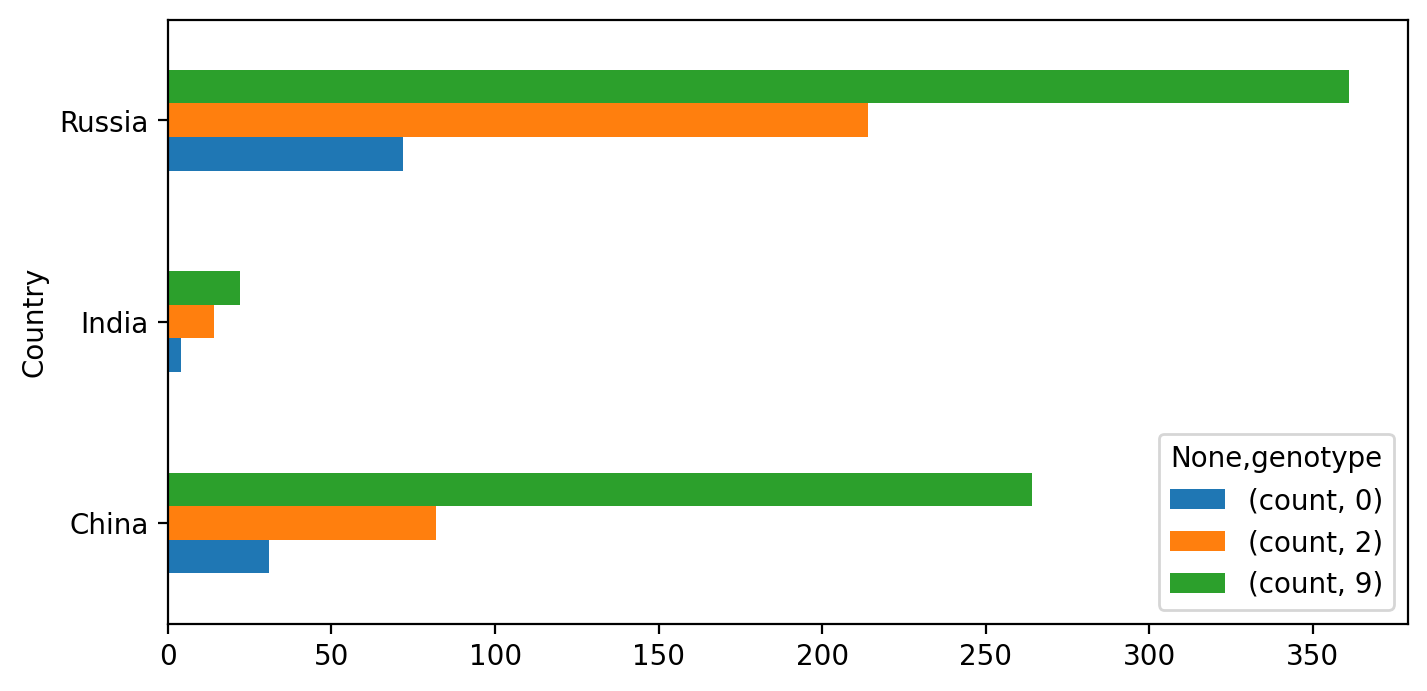

In [12]:
dist_geno_by_metadata(ind_file, geno_csv_file, "Country", 
                      ["China", "India", "Russia"])

Thank God, I went through [alexisbcook's tutorial](https://www.kaggle.com/alexisbcook/interactive-maps) before. I didn't think I would ever use this in Genomics. Now I do.

Prepare a table suitable for folium, and also filter out missing genotype (9).

In [13]:
def prepare_genotype_map_df(indfile, entryfile):
    df = pd.merge(
            get_samples_genotypes(indfile, entryfile),
            metadatadf.loc[:, metadata_of_interest],
            left_index = True,
            right_index = True
        )
    df = df.loc[df["genotype"] != 9, :]
    df = df.loc[df["gender"] != 'U', :]
    df = df.loc[df['Country'] != '..']
    # # remove modern samples
    # df = df.loc[df["Date BP"] > 0, :]
    print(df.shape)
    return df

magee2_df = prepare_genotype_map_df(ind_file, geno_csv_file)

(7353, 10)


In [14]:
magee2_df.head()

,gender,status,genotype,Date BP,Group ID,Locality,Country,Lat.,Long.,Molecular Sex
sampleid,,,,,,,,,,
I13833,M,Albania_EarlyModern_oCaucasus,2,325,Albania_EarlyModern_oCaucasus,"Barç (Southeast, Korça Basin)",Albania,40.625278,20.801111,M
CAO009013,F,Cuba_CanimarAbajo_Archaic,2,1329,Cuba_CanimarAbajo_Archaic,"Matanzas City, Canimar Abajo",Cuba,23.038,-81.497,F
I2446,F,England_BellBeaker_highWHG,2,4215,England_BellBeaker_highWHG,"England, Oxfordshire, Yarnton",United Kingdom,51.7977,-1.313464,F
I6441,M,Iraq_PPNA_contam,2,3300,Iraq_PPNA_contam,Nemrik 9,Iraq,36.716667,42.85,M
I1679_enhanced,F,Jordan_PPNC,2,8800,Jordan_PPNC,'Ain Ghazal,Jordan,31.988,35.976,F


In [15]:
#check the red dots... also why male don't have 1 ref alleles but got 2?
magee2_df.loc[(magee2_df['gender'] == 'M') & (magee2_df['genotype'] == 1)]

,gender,status,genotype,Date BP,Group ID,Locality,Country,Lat.,Long.,Molecular Sex
sampleid,,,,,,,,,,


#plotting frequency of derived allele over time

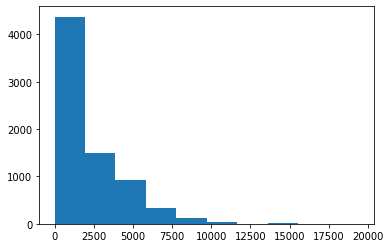

oldest sample date: 110450


In [16]:
import numpy as np

plt.hist(magee2_df.loc[magee2_df['Date BP'] < 20000]['Date BP'])
plt.show()
print('oldest sample date:', max(magee2_df['Date BP']))

In [17]:
#magee2_df.loc[ (magee2_df['Date BP'] < 10000) & (magee2_df['Date BP'] > 4000) ]
print(len(magee2_df.loc[magee2_df['Date BP'] == 0]))
print(len(magee2_df.loc[magee2_df['Date BP'] < 1000]))

2777
3429


In [18]:
#erase duplicate ust-ishim sample
magee2_df = magee2_df.drop('UstIshim_snpAD.DG')

In [19]:
intervals = []
for i in range(0, 10000, 1000):
  intervals.append((i, i + 999))
for i in range(10000, 50000, 5000):
  intervals.append((i, i+4999))
print(intervals)
print(len(intervals))

[(0, 999), (1000, 1999), (2000, 2999), (3000, 3999), (4000, 4999), (5000, 5999), (6000, 6999), (7000, 7999), (8000, 8999), (9000, 9999), (10000, 14999), (15000, 19999), (20000, 24999), (25000, 29999), (30000, 34999), (35000, 39999), (40000, 44999), (45000, 49999)]
18


In [20]:
for interval in intervals:
  print(interval)
  magee2_interval = magee2_df.loc[(magee2_df['Date BP'] >= interval[0]) & (magee2_df['Date BP'] <= interval[1])]
  print(len(magee2_interval), 'samples')

(0, 999)
3429 samples
(1000, 1999)
966 samples
(2000, 2999)
826 samples
(3000, 3999)
755 samples
(4000, 4999)
546 samples
(5000, 5999)
336 samples
(6000, 6999)
163 samples
(7000, 7999)
162 samples
(8000, 8999)
73 samples
(9000, 9999)
29 samples
(10000, 14999)
33 samples
(15000, 19999)
6 samples
(20000, 24999)
1 samples
(25000, 29999)
1 samples
(30000, 34999)
10 samples
(35000, 39999)
4 samples
(40000, 44999)
4 samples
(45000, 49999)
2 samples


In [21]:
#for frequency
magee2_freq = {}

for interval in intervals:
  #print(interval)
  magee2_interval = magee2_df.loc[(magee2_df['Date BP'] >= interval[0]) & (magee2_df['Date BP'] < interval[1])]
  reference_allele_count = len(magee2_interval.loc[(magee2_interval['gender'] == 'M') & (magee2_interval['genotype'] == 2)]) + \
  2*len(magee2_interval.loc[(magee2_interval['gender'] == 'F') & (magee2_interval['genotype'] == 2)]) + \
  len(magee2_interval.loc[(magee2_interval['gender'] == 'F') & (magee2_interval['genotype'] == 1)])
  #print('reference allele count', reference_allele_count)
  total_allele_count = len(magee2_interval.loc[magee2_interval['gender'] == 'M']) + 2*len(magee2_interval.loc[magee2_interval['gender'] == 'F'])
  #print('total allele count', total_allele_count)
  if total_allele_count != 0:
    magee2_freq[interval] = (total_allele_count - reference_allele_count)/total_allele_count
  else:
    magee2_freq[interval] = 0

In [22]:
#for count
derived_count = []
reference_count = []

for interval in intervals:
  #print(interval)
  magee2_interval = magee2_df.loc[(magee2_df['Date BP'] >= interval[0]) & (magee2_df['Date BP'] < interval[1])]
  reference_allele_count = len(magee2_interval.loc[(magee2_interval['gender'] == 'M') & (magee2_interval['genotype'] == 2)]) + \
  2*len(magee2_interval.loc[(magee2_interval['gender'] == 'F') & (magee2_interval['genotype'] == 2)]) + \
  len(magee2_interval.loc[(magee2_interval['gender'] == 'F') & (magee2_interval['genotype'] == 1)])
  #print('reference allele count', reference_allele_count)
  total_allele_count = len(magee2_interval.loc[magee2_interval['gender'] == 'M']) + 2*len(magee2_interval.loc[magee2_interval['gender'] == 'F'])
  #print('total allele count', total_allele_count)
  derived_count.append(total_allele_count - reference_allele_count)
  reference_count.append(reference_allele_count)

In [23]:
for n in range(0, 18):
  print(derived_count[n], 'derived', reference_count[n], 'reference', derived_count[n] + reference_count[n], 'total')

1486 derived 3640 reference 5126 total
243 derived 1188 reference 1431 total
170 derived 1086 reference 1256 total
89 derived 1078 reference 1167 total
65 derived 746 reference 811 total
47 derived 449 reference 496 total
22 derived 234 reference 256 total
34 derived 206 reference 240 total
12 derived 105 reference 117 total
7 derived 38 reference 45 total
5 derived 40 reference 45 total
1 derived 8 reference 9 total
0 derived 1 reference 1 total
0 derived 1 reference 1 total
2 derived 12 reference 14 total
0 derived 4 reference 4 total
2 derived 4 reference 6 total
1 derived 1 reference 2 total


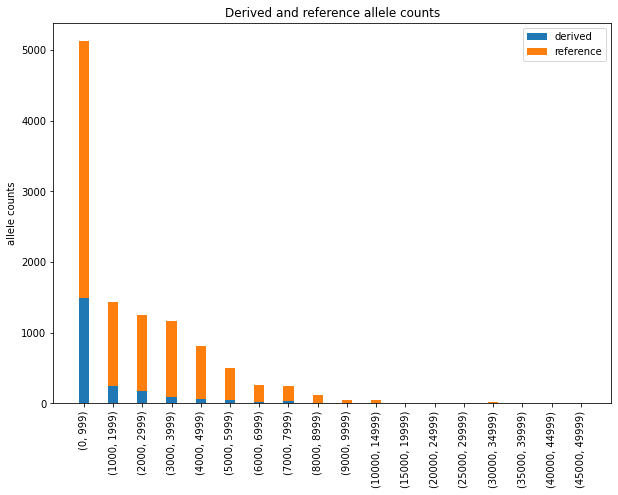

In [24]:
width = 0.35 
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(np.arange(len(intervals)), derived_count, width)
p2 = plt.bar(np.arange(len(intervals)), reference_count, width,
             bottom = derived_count)

plt.ylabel('allele counts')
plt.title('Derived and reference allele counts')
plt.xticks(np.arange(len(intervals)), intervals, rotation=90)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('derived', 'reference'))

plt.show()

In [25]:
continent_df = pd.read_csv('/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/continent.csv', sep = ",",
                      names = ["continent", "country"])

In [26]:
continent_dict = {'Africa':[],
                  'Central and South Asia':[],
                  'Eastern Asia':[],
                  'Western Asia':[],
                  'Europe':[],
                  'America':[],
                  'Oceania':[],
                  'Russia':[]}

unsorted = []

for country in np.unique(magee2_df['Country']):
  if country in list(continent_df['country']):
    continent = continent_df.loc[continent_df['country'] == country]['continent'].values[0]
    continent_dict[continent].append(country)
  else:
    unsorted.append(country)

In [27]:
magee2_df['continent'] = ''

In [28]:
#assigning continent to each individual in magee2_df
for i in range(len(magee2_df)):
  country = magee2_df[i:i+1]['Country'].values[0]
  for j in range(len(list(continent_dict.values()))):
    if country in list(continent_dict.values())[j]:
      continent = list(continent_dict.keys())[j]
  magee2_df.loc[magee2_df[i:i+1].index.values[0], 'continent'] = continent

In [29]:
# converting long lat to floats
for i in list(magee2_df.index):
  if magee2_df.at[i, 'Lat.'] != '..':
    magee2_df.at[i, 'Lat.'] = float(magee2_df.at[i, 'Lat.'])
    magee2_df.at[i, 'Long.'] = float(magee2_df.at[i, 'Long.'])

In [30]:
#splitting russia into asia and europe
for i in list(magee2_df.loc[magee2_df['continent'] == 'Russia'].index):
  if magee2_df.at[i, 'Lat.'] != '..':
    latitude = magee2_df.at[i, 'Lat.']
    longitude = magee2_df.at[i, 'Long.']
    if longitude < 0 or longitude > 65:
      magee2_df.at[i, 'continent'] = 'Central and South Asia'
    else:
      magee2_df.at[i, 'continent'] = 'Europe'

In [31]:
# magee2_df = pd.read_csv('/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/rs1343879_individuals_with_continent.csv')

In [42]:
magee2_df.loc[(magee2_df['continent'] == 'Eastern Asia') & (magee2_df['Date BP'] < 10000)]

,gender,status,genotype,Date BP,Group ID,Locality,Country,Lat.,Long.,Molecular Sex,continent
sampleid,,,,,,,,,,,
S_Ami-1.DG,M,NaN,2,0,Ami.DG,..,Taiwan,22.843145,121.185356,M,Eastern Asia
S_Ami-2.DG,M,NaN,0,0,Ami.DG,..,Taiwan,22.843145,121.185356,M,Eastern Asia
S_Atayal-1.DG,M,NaN,0,0,Atayal.DG,..,Taiwan,24.611712,121.296444,M,Eastern Asia
HG00759.SG,F,NaN,2,0,CDX.SG,Dai Xishuangbanna,China,22.0,100.8,F,Eastern Asia
HG00766.SG,F,NaN,0,0,CDX.SG,Dai Xishuangbanna,China,22.0,100.8,F,Eastern Asia
HG00844.SG,M,NaN,0,0,CDX.SG,Dai Xishuangbanna,China,22.0,100.8,M,Eastern Asia
HG00851.SG,F,NaN,2,0,CDX.SG,Dai Xishuangbanna,China,22.0,100.8,F,Eastern Asia
HG00864.SG,F,NaN,0,0,CDX.SG,Dai Xishuangbanna,China,22.0,100.8,F,Eastern Asia
HG00867.SG,F,NaN,2,0,CDX.SG,Dai Xishuangbanna,China,22.0,100.8,F,Eastern Asia


In [32]:
magee2_df.head()

,gender,status,genotype,Date BP,Group ID,Locality,Country,Lat.,Long.,Molecular Sex,continent
sampleid,,,,,,,,,,,
I13833,M,Albania_EarlyModern_oCaucasus,2,325,Albania_EarlyModern_oCaucasus,"Barç (Southeast, Korça Basin)",Albania,40.625278,20.801111,M,Europe
CAO009013,F,Cuba_CanimarAbajo_Archaic,2,1329,Cuba_CanimarAbajo_Archaic,"Matanzas City, Canimar Abajo",Cuba,23.038,-81.497,F,America
I2446,F,England_BellBeaker_highWHG,2,4215,England_BellBeaker_highWHG,"England, Oxfordshire, Yarnton",United Kingdom,51.7977,-1.313464,F,Europe
I6441,M,Iraq_PPNA_contam,2,3300,Iraq_PPNA_contam,Nemrik 9,Iraq,36.716667,42.85,M,Western Asia
I1679_enhanced,F,Jordan_PPNC,2,8800,Jordan_PPNC,'Ain Ghazal,Jordan,31.988,35.976,F,Western Asia


In [33]:
#assigning the continent russia to proper continents

magee2_df.loc[magee2_df['Locality'] == 'Siberia', 'continent'] = 'Central and South Asia'
magee2_df.loc[(magee2_df['Locality'] != 'Siberia') & (magee2_df['continent'] == 'Russia'), 'continent'] = 'Central and South Asia'

In [34]:
list(set(magee2_df['continent']))

['Oceania',
 'Europe',
 'Eastern Asia',
 'America',
 'Africa',
 'Central and South Asia',
 'Western Asia']

In [35]:
#calculate derived count for each continent in different time intervals!
derived_count_cont = {'Africa':[],
                  'Central and South Asia':[],
                  'Eastern Asia':[],
                  'Western Asia':[],
                  'Europe':[],
                  'America':[],
                  'Oceania':[]}

ref_count_cont = {'Africa':[],
                  'Central and South Asia':[],
                  'Eastern Asia':[],
                  'Western Asia':[],
                  'Europe':[],
                  'America':[],
                  'Oceania':[]}


for cont in list(list(set(magee2_df['continent']))):
  magee2_df_cont = magee2_df.loc[magee2_df['continent'] == cont]
  for interval in intervals:
    #print(interval)
    magee2_interval = magee2_df_cont.loc[(magee2_df_cont['Date BP'] >= interval[0]) & (magee2_df_cont['Date BP'] < interval[1])]
    if len(magee2_interval) == 0:
      derived_count_cont[cont].append(0)
      ref_count_cont[cont].append(0)
    else:
      reference_allele_count = len(magee2_interval.loc[(magee2_interval['gender'] == 'M') & (magee2_interval['genotype'] == 2)]) + \
      2*len(magee2_interval.loc[(magee2_interval['gender'] == 'F') & (magee2_interval['genotype'] == 2)]) + \
      len(magee2_interval.loc[(magee2_interval['gender'] == 'F') & (magee2_interval['genotype'] == 1)])
      #print('reference allele count', reference_allele_count)
      total_allele_count = len(magee2_interval.loc[magee2_interval['gender'] == 'M']) + 2*len(magee2_interval.loc[magee2_interval['gender'] == 'F'])
      #print('total allele count', total_allele_count)
      derived_count_cont[cont].append(total_allele_count - reference_allele_count)
      ref_count_cont[cont].append(reference_allele_count)


In [36]:
# #divide all cont count by total count of that time interval
# #calculate derived frequency for each continent in different time intervals!
# derived_freq_cont = {'Africa':[],
#                   'Central and South Asia':[],
#                   'Eastern Asia':[],
#                   'Western Asia':[],
#                   'Europe':[],
#                   'America':[],
#                   'Oceania':[]}

# derived_freq_cont_lst = {'Time':[],
#                          'Continent':[],
#                          'Derived_Allele_Frequency':[]}

# for i in range(len(intervals)):
#   total_time_cont = sum([derived_count_cont[cont][i] + ref_count_cont[cont] for cont in derived_count_cont])
#   for cont in list(set(magee2_df['continent'])):
#     der_count = derived_count_cont[cont][i]
#     ref_count = ref_count_cont[cont][i]
#     total_count = der_count + ref_count
#     if total_time_cont == 0:
#       derived_freq_cont[cont].append(0)
#       derived_freq_cont_lst['Time'].append(intervals[i])
#       derived_freq_cont_lst['Continent'].append(cont)
#       derived_freq_cont_lst['Derived_Allele_Frequency'].append(0)
#     else:
#       derived_freq_cont[cont].append(der_count/total_time_cont)
#       derived_freq_cont_lst['Time'].append(intervals[i])
#       derived_freq_cont_lst['Continent'].append(cont)
#       derived_freq_cont_lst['Derived_Allele_Frequency'].append(der_count/total_time_cont)

In [37]:
# # old one that isn't formatted for ggplot

# lala = pd.DataFrame(derived_freq_cont_lst)
# lala.to_csv('/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/rs1343879_continent_derived_allele_frequency.csv', index=False)

In [38]:
# #if want whole cont derived/reference allele_counts for geom_text
# #this one is with derived/total allele counts. formatted for ggplot2 easy plotting

# lala = pd.DataFrame(derived_freq_cont_lst)
# lala['allele_counts'] = ' ' #initialize

# for i in range(0, len(intervals)):
#   label = str(derived_count[i]) + '/' + str(derived_count[i] + reference_count[i])
#   lala.loc[i*7+4, 'allele_counts'] = label

# for i in range(0, 18):
#   lala.loc[lala.Time == intervals[i], 'Time'] = 18 - i

# lala = lala.sort_values(by = ['Time', 'Continent'], ascending=[False, True])

# lala.to_csv('/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/rs1343879_continent_derived_allele_frequency.csv', index=False)

In [39]:
# # sanity check

# lala = []
# for cont in derived_freq_cont:
#   lala.append(derived_freq_cont[cont][0])

# print(sum(lala), list(magee2_freq.values())[0])

In [40]:
#scale all cont to 0-1
#calculate derived frequency for each continent in different time intervals!

derived_freq_cont_lst = {'Time':[],
                         'Continent':[],
                         'Derived_Allele_Frequency':[]}

for i in range(len(intervals)):
  for cont in list(set(magee2_df['continent'])):
    der_count = derived_count_cont[cont][i]
    ref_count = ref_count_cont[cont][i]
    total_count = der_count + ref_count
    if total_count == 0:
      derived_freq_cont_lst['Time'].append(intervals[i])
      derived_freq_cont_lst['Continent'].append(cont)
      derived_freq_cont_lst['Derived_Allele_Frequency'].append(0)
    else:
      derived_freq_cont_lst['Time'].append(intervals[i])
      derived_freq_cont_lst['Continent'].append(cont)
      derived_freq_cont_lst['Derived_Allele_Frequency'].append(der_count/total_count)

In [ ]:
#if want derived/reference allele_count for each cont in geom_text
#this one is with derived/total allele counts. formatted for ggplot2 easy plotting

lala = pd.DataFrame(derived_freq_cont_lst)
lala['allele_counts'] = ' ' #initialize
continents = list(list(set(magee2_df['continent'])))

for i in range(0, len(intervals)):
  total_time_cont = sum([derived_count_cont[cont][i] + ref_count_cont[cont][i] for cont in derived_count_cont])
  for cont in continents:
    # label = str(derived_count_cont[cont][i]) + '/' + str(derived_count_cont[cont][i] + ref_count_cont[cont][i])
    lala.loc[(lala['Continent'] == cont) & (lala['Time'] == intervals[i]), 'allele_counts'] = str(derived_count_cont[cont][i] + ref_count_cont[cont][i])


for i in range(0, 18):
  lala.loc[lala.Time == intervals[i], 'Time'] = 18 - i

lala = lala.sort_values(by = ['Time', 'Continent'], ascending=[False, True])

lala.to_csv('/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/rs1343879_continent_derived_allele_frequency.csv', index=False)

In [ ]:
lala

In [ ]:
lala = pd.DataFrame(list(magee2_freq.values()), columns = ['Derived_allele_frequency'])
lala.index = intervals
lala.to_csv('/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/rs1343879_total_derived_allele_frequency.csv', index=False)

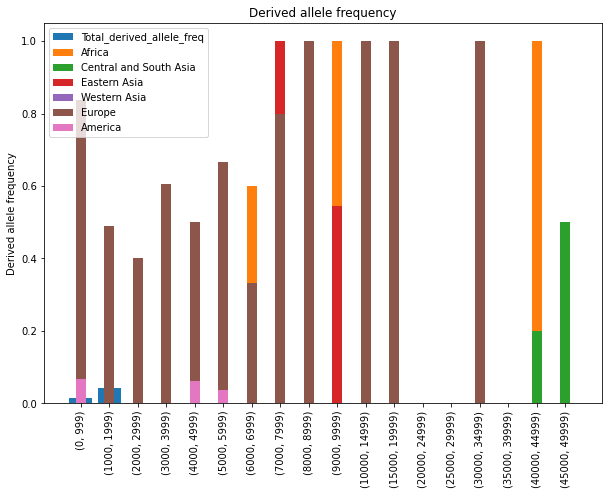

In [ ]:
width = 0.35 
fig = plt.subplots(figsize =(10, 7))
ranges = np.arange(len(intervals))

# p1 = plt.plot(ranges, list(magee2_freq.values()))
# p2 = plt.scatter(ranges, list(magee2_freq.values()), s=100)

p3 = plt.bar(ranges, derived_freq_cont['Africa'])
p4 = plt.bar(ranges, derived_freq_cont['Central and South Asia'], width)
p5 = plt.bar(ranges, derived_freq_cont['Europe'], width)
p6 = plt.bar(ranges, derived_freq_cont['America'], width)
p7 = plt.bar(ranges, derived_freq_cont['Oceania'], width)
p8 = plt.bar(ranges, derived_freq_cont['Eastern Asia'], width)
p9 = plt.bar(ranges, derived_freq_cont['Western Asia'], width)


plt.ylabel('Derived allele frequency')
plt.title('Derived allele frequency')
plt.xticks(ranges, intervals, rotation=90)
plt.legend((p3, p4, p5, p6, p7, p8, p9), ['Total_derived_allele_freq'] + list(continent_dict.keys()))

plt.show()

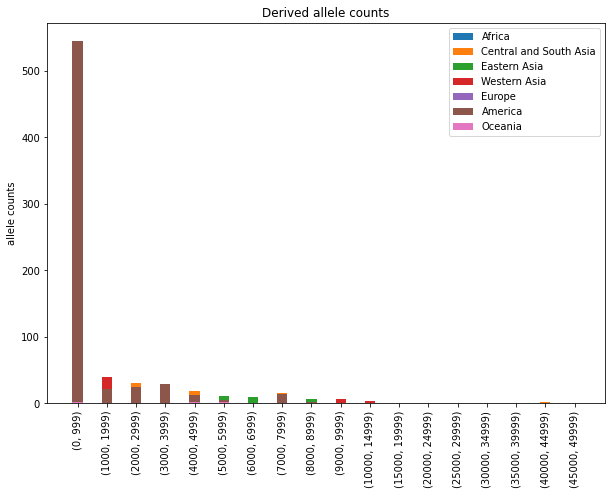

In [ ]:
width = 0.35 
fig = plt.subplots(figsize =(10, 7))
ranges = np.arange(len(intervals))
p1 = plt.bar(ranges, derived_count_cont['Africa'], width)
p2 = plt.bar(ranges, derived_count_cont['Central and South Asia'], width)
p3 = plt.bar(ranges, derived_count_cont['Europe'], width)
p4 = plt.bar(ranges, derived_count_cont['America'], width)
p5 = plt.bar(ranges, derived_count_cont['Oceania'], width)
p6 = plt.bar(ranges, derived_count_cont['Eastern Asia'], width)
p7 = plt.bar(ranges, derived_count_cont['Western Asia'], width)

plt.ylabel('allele counts')
plt.title('Derived allele counts')
plt.xticks(ranges, intervals, rotation=90)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), list(continent_dict.keys()))

plt.show()

In [ ]:
len(magee2_df.loc[(magee2_df['Date BP'] >= 0) & (magee2_df['Date BP'] < 1)])

2807

#FOLIUM PLOTS THAT DON'T WORK NOW LOL

In [ ]:
from IPython.display import display

m_1 = folium.Map(location = [0, 0],
                 tiles = 'openstreetmap',
                 zoom_start = 1.4)

MousePosition().add_to(m_1)

mc = MarkerCluster()
for idx, row in magee2_df.iterrows():
    try:
        latitude = float(row["Lat."])
        longitude = float(row["Long."])
        tooltip = str(row["Country"])
        marker = Marker([latitude, longitude], tooltip = tooltip)
        mc.add_child(marker)
    except:
        pass

m_1.add_child(mc)
display(m_1)

In [ ]:
dm_1 = folium.Map(location = [0, 180],
                 tiles = 'openstreetmap',
                 zoom_start = 1.4,
                 zoom_control = True)

MousePosition().add_to(m_1)

mc = MarkerCluster()
for idx, row in magee2_df.iterrows():
    try:
        if float(row["Long."]) < -20:
            latitude = float(row["Lat."])
            longitude = float(row["Long."]) + 360
            
        else:
            latitude = float(row["Lat."])
            longitude = float(row["Long."])
        
        tooltip = str(row["Country"])
        marker = Marker([latitude, longitude], tooltip = tooltip)
        mc.add_child(marker)
    except:
        pass

m_1.add_child(mc)
m_1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def prepare_genotype_map_df(indfile, entryfile):
    df = pd.merge(
            get_samples_genotypes(indfile, entryfile),
            metadatadf.loc[:, metadata_of_interest],
            left_index = True,
            right_index = True
        )
    df = df.loc[df["genotype"] != 9, :]
    # remove modern samples
    # df = df.loc[df["Date BP"] > 0, :]
    # df = df.loc[df['Country'] == 'Russia', :]
    return df

def color_producer(val):
    if val == 0:
        return 'limegreen'
    elif val == 1:
        return 'red'
    elif val == 2:
        return 'blue'

def plot_insertfile(insertfile):
    insert_df = prepare_genotype_map_df(ind_file, insertfile)
    map_plot = folium.Map(location=[0, 180],
                     tiles='cartodbpositron',
                     zoom_start = 1,
                     zoom_control = True)
    
    MousePosition().add_to(map_plot)

    title_html = '''
                 <h3 align="center" style="font-size:22px"><b>{}</b></h3>
                 '''.format('lalala')
    map_plot.get_root().html.add_child(folium.Element(title_html))
    
    for idx, row in insert_df.iterrows():
        try:
            if float(row["Long."]) < -20:
                latitude = float(row["Lat."])
                longitude = float(row["Long."]) + 360

            else:
                latitude = float(row["Lat."])
                longitude = float(row["Long."])

            color = color_producer(row["genotype"])
            country = str(row["Country"])
            date = int(row["Date BP"])
            groupid = str(row["GroupID"])

            tooltip = f"Date: {date} BP, Country: {country}, groupID: {groupid}"

            circle = folium.Circle(
                radius=100,
                location = [latitude, longitude],
                tooltip = tooltip,
                color=color,
                fill= True,
                fill_color=color)

            circle.add_to(map_plot)
        except:
            pass

    return map_plot

plot_insertfile(geno_csv_file)

|color|genotype|meaning|
|-|-|-|
|green|0|zero copies of reference allele.|
|red|1|one copy of reference allele.|
|blue|2|two copies of reference allele.|

#Generating a new df for each millenia?

In [ ]:
magee2_df_derived = magee2_df.loc[magee2_df['genotype'] != 2]
magee2_df_derived.drop(magee2_df_derived[(magee2_df_derived["genotype"] == 1) & (magee2_df_derived["gender"] == 'M')].index, inplace=True)

In [ ]:
sorted_df = magee2_df_derived.sort_values("Date BP", ascending=False)
sorted_df.head()

,Unnamed: 0,gender,status,genotype,Date BP,GroupID,Locality,Country,Lat.,Long.,Sex,continent
376,Ust_Ishim_published.DG,M,Russia_Ust_Ishim_HG_published.DG,0,44366,Russia_Ust_Ishim_HG_published.DG,"Ust'-Ishim, Siberia",Russia,57.7,71.1,M,Central and South Asia
370,UstIshim_snpAD.DG,M,Russia_Ust_Ishim.DG,0,44366,Russia_Ust_Ishim.DG,"Ust'-Ishim, Siberia",Russia,57.7,71.1,M,Central and South Asia
3756,USR2.SG,F,USA_Ancient_Beringian.SG,0,11425,USA_Ancient_Beringian.SG,Upward Sun River,USA,64.22,-145.7,F,America
3755,USR1.SG,F,USA_Ancient_Beringian.SG,0,11425,USA_Ancient_Beringian.SG,Upward Sun River,USA,64.22,-145.7,F,America
3354,I5241,F,Serbia_IronGates_Mesolithic_daughter_I5236,0,11198,Serbia_IronGates_Mesolithic_daughter_I5236,Padina,Serbia,44.595879,22.010568,F,Europe


In [ ]:
sorted_df.shape

(1121, 12)

In [ ]:
bins = []
interval = 10000
max = 110000
counter = max #init
for i in range(max//interval):
  bins.append(counter)
  counter -= interval

interval = 1000
max = 9000
counter = max #init

for i in range(max//interval):
  bins.append(counter)
  counter -= interval

bins.append(0)
print(bins)

[110000, 100000, 90000, 80000, 70000, 60000, 50000, 40000, 30000, 20000, 10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000, 0]


In [ ]:
def color_producer(val):
    if val == 0:
        return 'blue'
    elif val == 1:
        return 'blue'
    # elif val == 2:
    #     return 'blue'

def plot_df_threshold(insert_df, year):
    map_plot = folium.Map(location=[0, 180],
                     tiles='cartodbpositron',
                     zoom_start = 1.25,
                     zoom_control = False)
    
    # MousePosition().add_to(map_plot)

    # Add year label to the map
    title_html = '''
                 <h3 align="center" style="font-size:22px"><b>{}</b></h3>
                 '''.format('Before ' + str(year) + 'BP')
    map_plot.get_root().html.add_child(folium.Element(title_html))
    
    for idx, row in insert_df.iterrows():
        try:
            if float(row["Long."]) < -20:
                latitude = float(row["Lat."])
                longitude = float(row["Long."]) + 360

            else:
                latitude = float(row["Lat."])
                longitude = float(row["Long."])

            color = color_producer(row["genotype"])
            country = str(row["Country"])
            date = int(row["Date BP"])
            groupid = str(row["GroupID"])

            tooltip = f"Date: {date} BP, Country: {country}, groupID: {groupid}"

            circle = folium.Circle(
                radius=100,
                location = [latitude, longitude],
                tooltip = tooltip,
                color=color,
                fill= True,
                fill_color=color)

            circle.add_to(map_plot)
        except:
            pass

    return map_plot

In [ ]:
for i in range(len(bins)):
  df_processed = sorted_df[sorted_df["Date BP"] >= bins[i]]
  print(bins[i], df_processed.shape)
  plot = plot_df_threshold(df_processed, bins[i])
  plot.save(f"/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/maps_BP/{bins[i]}_BP_magee2.html")

110000 (0, 12)
100000 (0, 12)
90000 (0, 12)
80000 (0, 12)
70000 (0, 12)
60000 (0, 12)
50000 (0, 12)
40000 (2, 12)
30000 (2, 12)
20000 (2, 12)
10000 (5, 12)
9000 (11, 12)
8000 (17, 12)
7000 (37, 12)
6000 (49, 12)
5000 (68, 12)
4000 (100, 12)
3000 (140, 12)
2000 (187, 12)
1000 (252, 12)
0 (1121, 12)


In [ ]:
!pip install selenium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 995 kB 5.0 MB/s 
     |████████████████████████████████| 384 kB 33.9 MB/s 
     |████████████████████████████████| 140 kB 42.7 MB/s 
     |████████████████████████████████| 58 kB 5.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


In [ ]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,554 

In [ ]:
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 19 not upgraded.
Need to get 91.7 MB of archives.
After this operation, 309 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 105.0.5195.102-0ubuntu0.18.04.1 [1,156 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 105.0.5195.102-0ubuntu0.

In [ ]:
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


<html lang="en-US"><head>
    <title>Just a moment...</title>
    <meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=Edge">
    <meta name="robots" content="noindex,nofollow">
    <meta name="viewport" content="width=device-width,initial-scale=1">
    <link href="/cdn-cgi/styles/challenges.css" rel="stylesheet">
    

<script src="/cdn-cgi/challenge-platform/h/b/orchestrate/managed/v1?ray=763b1625bb56acf1"></script><script src="https://cloudflare.hcaptcha.com/1/api.js?endpoint=https%3A%2F%2Fcloudflare.hcaptcha.com&amp;assethost=https%3A%2F%2Fcf-assets.hcaptcha.com&amp;imghost=https%3A%2F%2Fcf-imgs.hcaptcha.com&amp;render=explicit&amp;recaptchacompat=off&amp;onload=_cf_chl_hload"></script></head>
<body class="no-js">
    <div class="main-wrapper" role="main">
    <div class="main-content">
        <h1 class="zone-name-title h1">
            <img class="heading-favicon" src="/favicon.ico" onerror="this.onerror=null;this.
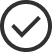

In [ ]:
import os
import time
import imageio
from selenium import webdriver

options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# open it, go to a website, and get results
wd = webdriver.Chrome('chromedriver',options=options)
wd.get("https://www.website.com")
print(wd.page_source)  # results

In [ ]:
# Convert html files to png (screenshot each html page)

# We use a delay because we dont want to take a screenshot of the browser before the map is loaded
delay=10

path = "/content/drive/MyDrive/AAA_Honours/v54.1_1240K_public/maps_BP"

os.chdir(path)

for i in range(len(bins)):
    fn = f"{bins[i]}_BP_magee2.html"
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)

    browser = webdriver.Chrome('chromedriver', options=options)
    browser.get(tmpurl)

    #Give the map tiles some time to load
    time.sleep(delay)
    browser.save_screenshot(f"{bins[i]}_BP_magee2.png")
    browser.quit()
    
    #remove html files
    os.remove(f"{bins[i]}_BP_magee2.html")

In [ ]:
from PIL import Image
from pathlib import Path

In [ ]:
# Cropping images for better visualization

for i in range(len(bins)):
    image = Image.open(f"{bins[i]}_BP_magee2.png")
    box = (108, 0, 635, 470)
    cropped_image = image.crop(box)
    cropped_image.save(f"{bins[i]}_BP_magee2.png")

In [ ]:
# Create Gif and remove each .png file

image_path = Path()

images = list(image_path.glob('*.png'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
    os.remove(file_name)
    
imageio.mimwrite('GifMap_blue_magee2.gif', image_list, fps=2)